Importation des données et création des rendements :

In [1]:
# ============================================================
# BTC/ETH - Copules - VaR - Backtesting 
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.special import gammaln
from scipy.stats import gaussian_kde
from statsmodels.stats.stattools import jarque_bera
import yfinance as yf


# ============================================================
# 0) Utils
# ============================================================
def print_header(title: str):
    print("\n" + "=" * 10 + f" {title} " + "=" * 10)

def safe_clip01(u, eps=1e-6):
    return np.clip(u, eps, 1 - eps)

def skew_kurt(x):
    sk = stats.skew(x, bias=False)
    ku = stats.kurtosis(x, fisher=False, bias=False)  # kurtosis "classique" (Normal=3)
    return sk, ku

def pt_student(x, df, m, s):
    return stats.t.cdf((x - m) / s, df=df)

def qt_student(u, df, m, s):
    return m + s * stats.t.ppf(u, df=df)

def aic_from_loglik(loglik, k):
    return 2 * k - 2 * loglik


# ============================================================
# 1) Importation des données + rendements log
# ============================================================
tickers = ["BTC-USD", "ETH-USD"]
start_date = "2022-01-01"

data = yf.download(tickers, start=start_date, auto_adjust=False, progress=False)
close = data["Close"].copy()

btc = close["BTC-USD"].dropna()
eth = close["ETH-USD"].dropna()

rbtc = np.log(btc).diff().dropna()
reth = np.log(eth).diff().dropna()

df_ret = pd.concat([rbtc.rename("BTC"), reth.rename("ETH")], axis=1).dropna()
X = df_ret["BTC"].to_numpy()
Y = df_ret["ETH"].to_numpy()
dates = df_ret.index
n = len(df_ret)

print_header("Taille échantillon")
print("n =", n)








========== Taille échantillon ==========
n = 1444


Analyse descriptive :


========== Statistiques descriptives ==========
Actif   Moyenne   Mediane  Ecart_type  Skewness  Kurtosis       Min      Max
  BTC  0.000414 -0.000240    0.027091 -0.152313  7.439644 -0.174053 0.135764
  ETH -0.000160  0.000165    0.036676 -0.052640  7.052104 -0.191844 0.197200


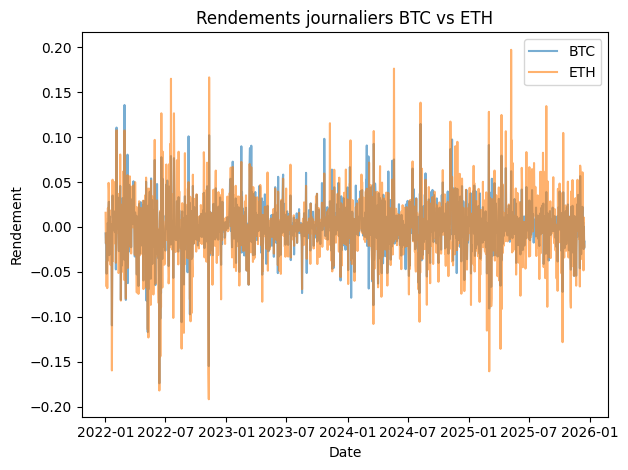

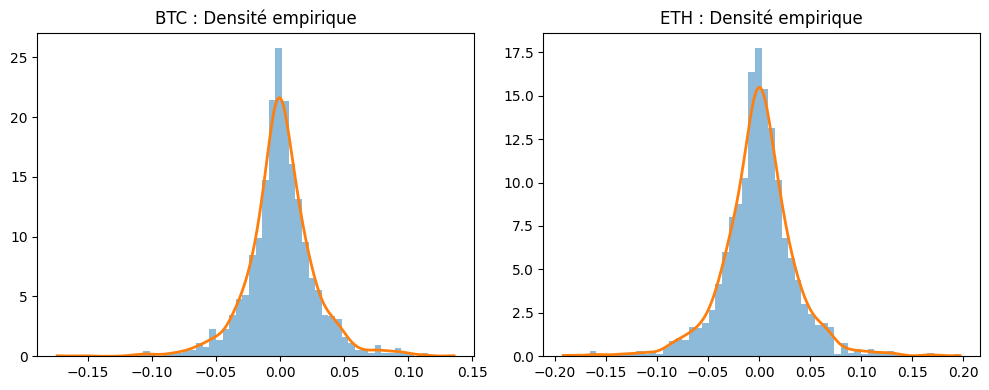

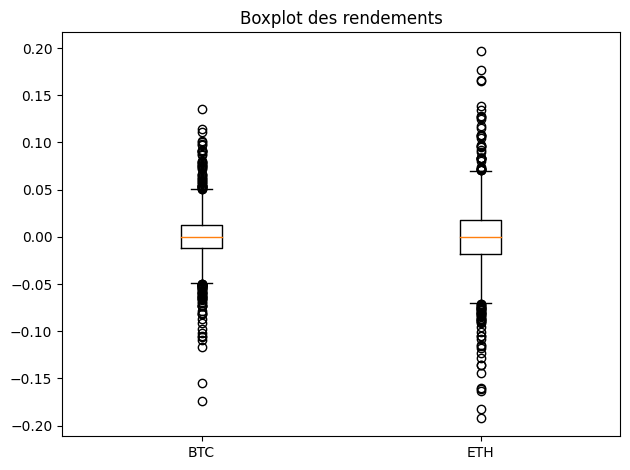

In [2]:
# ============================================================
# 1bis) Analyse descriptive
# ============================================================
print_header("Statistiques descriptives")
skX, kuX = skew_kurt(X)
skY, kuY = skew_kurt(Y)

stats_df = pd.DataFrame({
    "Actif": ["BTC", "ETH"],
    "Moyenne": [X.mean(), Y.mean()],
    "Mediane": [np.median(X), np.median(Y)],
    "Ecart_type": [X.std(ddof=1), Y.std(ddof=1)],
    "Skewness": [skX, skY],
    "Kurtosis": [kuX, kuY],
    "Min": [X.min(), Y.min()],
    "Max": [X.max(), Y.max()]
})
print(stats_df.to_string(index=False))

# ============================================================
# 2) Graphique temporel des rendements
# ============================================================
plt.figure()
plt.plot(dates, X, alpha=0.6, label="BTC")
plt.plot(dates, Y, alpha=0.6, label="ETH")
plt.title("Rendements journaliers BTC vs ETH")
plt.xlabel("Date")
plt.ylabel("Rendement")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 3) Histogrammes + densité empirique
# ============================================================
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(X, bins=60, density=True, alpha=0.5)
kdeX = gaussian_kde(X)
xx = np.linspace(X.min(), X.max(), 400)
ax1.plot(xx, kdeX(xx), linewidth=2)
ax1.set_title("BTC : Densité empirique")

ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(Y, bins=60, density=True, alpha=0.5)
kdeY = gaussian_kde(Y)
yy = np.linspace(Y.min(), Y.max(), 400)
ax2.plot(yy, kdeY(yy), linewidth=2)
ax2.set_title("ETH : Densité empirique")

plt.tight_layout()
plt.show()

# ============================================================
# 4) Boxplots
# ============================================================
plt.figure()
plt.boxplot([X, Y], labels=["BTC", "ETH"])
plt.title("Boxplot des rendements")
plt.tight_layout()
plt.show()

Detection de la dépendance entre les rendements du BTC et ETH :


========== Corrélations ==========
Corrélation de Pearson  : 0.83800217219552
Corrélation de Spearman : 0.8187216639094831
Corrélation de Kendall  : 0.638933201260071


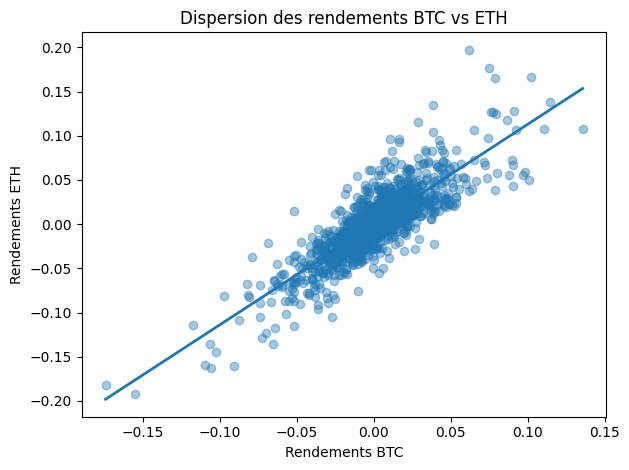

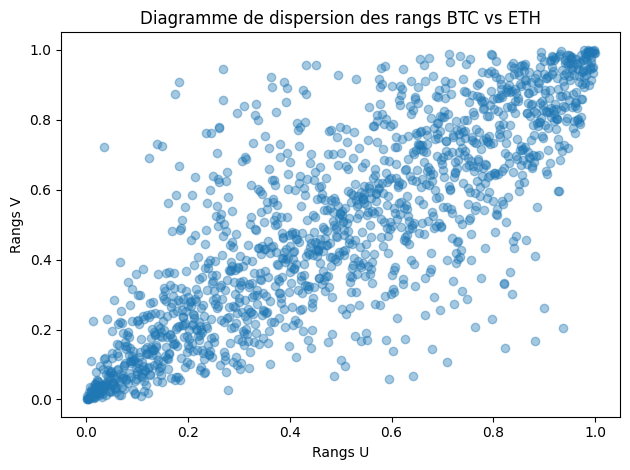

C:\Users\hbih\AppData\Local\Temp\ipykernel_30860\390919977.py:59: RuntimeWarning: invalid value encountered in divide
  chi = (Hi - Fi * Gi) / den


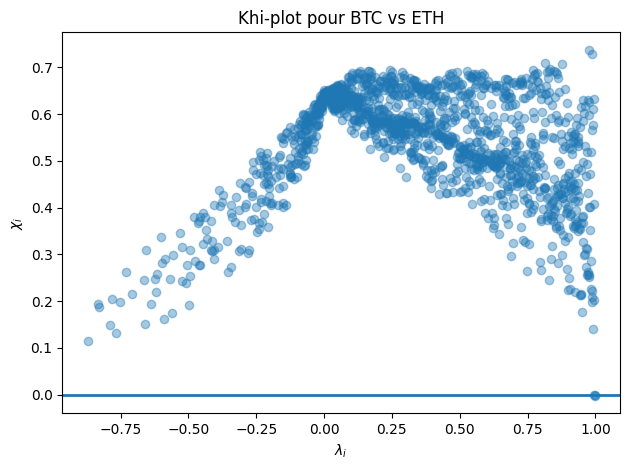

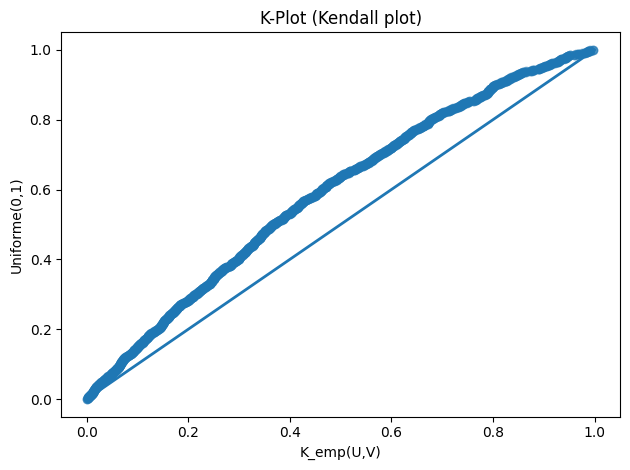

In [3]:
# ============================================================
# 5) Corrélations (Pearson, Spearman, Kendall)
# ============================================================
print_header("Corrélations")
cor_pearson = np.corrcoef(X, Y)[0, 1]
cor_spearman = stats.spearmanr(X, Y).correlation
cor_kendall = stats.kendalltau(X, Y).correlation

print("Corrélation de Pearson  :", cor_pearson)
print("Corrélation de Spearman :", cor_spearman)
print("Corrélation de Kendall  :", cor_kendall)



# ============================================================
# 7) Nuage de points + droite de régression
# ============================================================
plt.figure()
plt.scatter(X, Y, alpha=0.4)
b1, b0 = np.polyfit(X, Y, 1)
xline = np.linspace(X.min(), X.max(), 200)
plt.plot(xline, b1 * xline + b0, linewidth=2)
plt.xlabel("Rendements BTC")
plt.ylabel("Rendements ETH")
plt.title("Dispersion des rendements BTC vs ETH")
plt.tight_layout()
plt.show()

# ============================================================
# 8) Pseudo-observations via rangs
# ============================================================
U = stats.rankdata(X, method="average") / (n + 1.0)
V = stats.rankdata(Y, method="average") / (n + 1.0)

plt.figure()
plt.scatter(U, V, alpha=0.4)
plt.xlabel("Rangs U")
plt.ylabel("Rangs V")
plt.title("Diagramme de dispersion des rangs BTC vs ETH")
plt.tight_layout()
plt.show()

# ============================================================
# 9) Khi-plot (O(n^2), comme le R)
# ============================================================
Hi = np.zeros(n)
Fi = np.zeros(n)
Gi = np.zeros(n)

for i in range(n):
    mask = np.ones(n, dtype=bool)
    mask[i] = False
    Xi, Yi = X[i], Y[i]
    Hi[i] = np.mean((X[mask] <= Xi) & (Y[mask] <= Yi))
    Fi[i] = np.mean(X[mask] <= Xi)
    Gi[i] = np.mean(Y[mask] <= Yi)

den = np.sqrt(Fi * (1 - Fi) * Gi * (1 - Gi))
chi = (Hi - Fi * Gi) / den

lambda_i = 4 * np.sign(Fi - 0.5) * np.sign(Gi - 0.5) * np.maximum((Fi - 0.5) ** 2, (Gi - 0.5) ** 2)

plt.figure()
plt.scatter(lambda_i, chi, alpha=0.4)
plt.axhline(0, linewidth=2)
plt.xlabel(r"$\lambda_i$")
plt.ylabel(r"$\chi_i$")
plt.title("Khi-plot pour BTC vs ETH")
plt.tight_layout()
plt.show()

# ============================================================
# 10) K-plot (Kendall plot standard)
# ============================================================
K_emp = np.zeros(n)
for i in range(n):
    K_emp[i] = np.mean((U <= U[i]) & (V <= V[i]))

K_sorted = np.sort(K_emp)
u_uniform = np.arange(1, n + 1) / n

plt.figure()
plt.scatter(K_sorted, u_uniform, alpha=0.5)
plt.plot([0, 1], [0, 1], linewidth=2)
plt.xlabel("K_emp(U,V)")
plt.ylabel("Uniforme(0,1)")
plt.title("K-Plot (Kendall plot)")
plt.tight_layout()
plt.show()

Modélisations des fonctions de répartiitons des marges (BTC et ETH) :

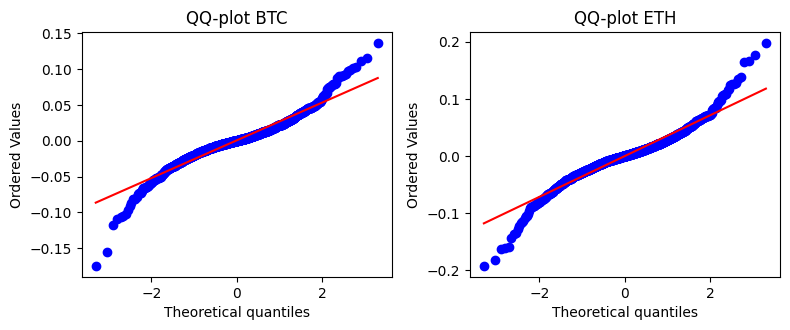


========== Test de normalité BTC ==========
Shapiro-Wilk: ShapiroResult(statistic=0.9404482352630084, pvalue=1.227670671820877e-23)
Jarque-Bera: statistic = 1181.0829338505177 , p-value = 3.397031541401737e-257

========== Test de normalité ETH ==========
Shapiro-Wilk: ShapiroResult(statistic=0.9449364980032599, pvalue=8.714656281771857e-23)
Jarque-Bera: statistic = 979.7354144168669 , p-value = 1.7912569843446004e-213


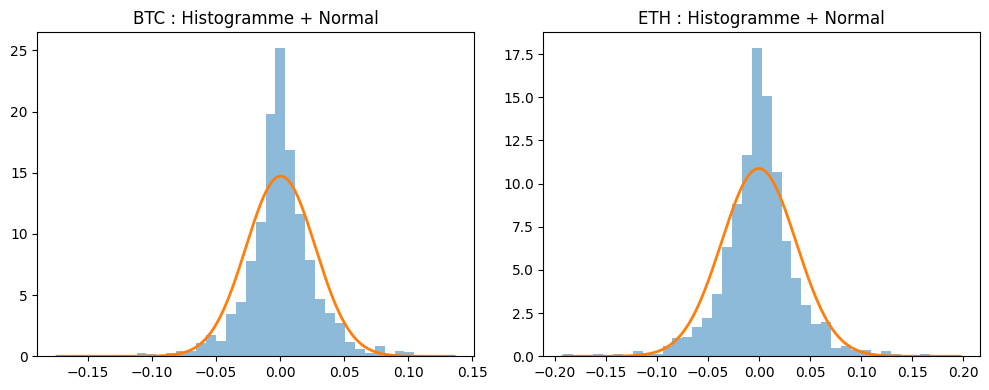


========== Student-t MLE BTC ==========
{'df': 2.7565354938472453, 'm': 0.00023883980306270956, 's': 0.016664797350887377}

========== Student-t MLE ETH ==========
{'df': 2.9660342125914902, 'm': 8.8457967220269e-05, 's': 0.023395123147047468}


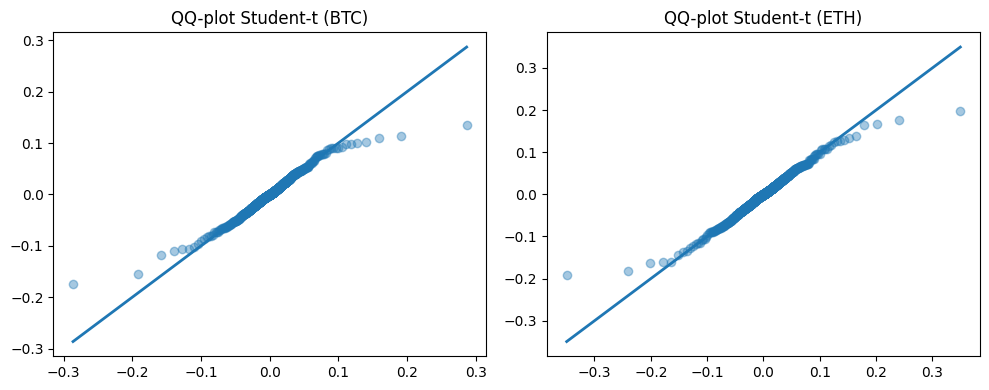


========== KS-test Student BTC ==========
KstestResult(statistic=0.021974005792463114, pvalue=0.4816229793466712, statistic_location=0.004714100093913487, statistic_sign=1)

========== KS-test Student ETH ==========
KstestResult(statistic=0.02120193691174488, pvalue=0.5279329518453241, statistic_location=-0.009638052931704166, statistic_sign=-1)

========== Comparaison AIC BTC ==========
AIC Normale : -6320.639065211395
AIC Student : -6602.486734820586

========== Comparaison AIC ETH ==========
AIC Normale : -5445.761793055959
AIC Student : -5705.046329218419


In [4]:
# ============================================================
# 11) Normalité : QQ-plots + Shapiro + Jarque-Bera
# ============================================================
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(2, 2, 1)
stats.probplot(X, dist="norm", plot=ax1)
ax1.set_title("QQ-plot BTC")

ax2 = fig.add_subplot(2, 2, 2)
stats.probplot(Y, dist="norm", plot=ax2)
ax2.set_title("QQ-plot ETH")

plt.tight_layout()
plt.show()

print_header("Test de normalité BTC")
print("Shapiro-Wilk:", stats.shapiro(X))
jbX = jarque_bera(X)
print("Jarque-Bera: statistic =", jbX[0], ", p-value =", jbX[1])

print_header("Test de normalité ETH")
print("Shapiro-Wilk:", stats.shapiro(Y))
jbY = jarque_bera(Y)
print("Jarque-Bera: statistic =", jbY[0], ", p-value =", jbY[1])

# ============================================================
# 12) Histogrammes + densité normale ajustée
# ============================================================
mX, sXn = X.mean(), X.std(ddof=1)
mY, sYn = Y.mean(), Y.std(ddof=1)

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(X, bins=40, density=True, alpha=0.5)
xx = np.linspace(X.min(), X.max(), 400)
ax1.plot(xx, stats.norm.pdf(xx, loc=mX, scale=sXn), linewidth=2)
ax1.set_title("BTC : Histogramme + Normal")

ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(Y, bins=40, density=True, alpha=0.5)
yy = np.linspace(Y.min(), Y.max(), 400)
ax2.plot(yy, stats.norm.pdf(yy, loc=mY, scale=sYn), linewidth=2)
ax2.set_title("ETH : Histogramme + Normal")

plt.tight_layout()
plt.show()

# ============================================================
# 13) Ajustement Student-t (MLE) + QQ + KS + AIC
# ============================================================
print_header("Student-t MLE BTC")
df_X, mu_X, s_X = stats.t.fit(X)
print({"df": df_X, "m": mu_X, "s": s_X})

print_header("Student-t MLE ETH")
df_Y, mu_Y, s_Y = stats.t.fit(Y)
print({"df": df_Y, "m": mu_Y, "s": s_Y})

# QQ Student-t
pp = (np.arange(1, n + 1) - 0.5) / n
qX = qt_student(pp, df_X, mu_X, s_X)
qY = qt_student(pp, df_Y, mu_Y, s_Y)

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(qX, np.sort(X), alpha=0.4)
ax1.plot([qX.min(), qX.max()], [qX.min(), qX.max()], linewidth=2)
ax1.set_title("QQ-plot Student-t (BTC)")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(qY, np.sort(Y), alpha=0.4)
ax2.plot([qY.min(), qY.max()], [qY.min(), qY.max()], linewidth=2)
ax2.set_title("QQ-plot Student-t (ETH)")

plt.tight_layout()
plt.show()

# KS Student-t
print_header("KS-test Student BTC")
ks_btc = stats.kstest(X, lambda z: pt_student(z, df_X, mu_X, s_X))
print(ks_btc)

print_header("KS-test Student ETH")
ks_eth = stats.kstest(Y, lambda z: pt_student(z, df_Y, mu_Y, s_Y))
print(ks_eth)

# AIC normal vs Student
ll_norm_X = np.sum(stats.norm.logpdf(X, loc=mX, scale=sXn))
ll_norm_Y = np.sum(stats.norm.logpdf(Y, loc=mY, scale=sYn))
aic_norm_X = aic_from_loglik(ll_norm_X, k=2)
aic_norm_Y = aic_from_loglik(ll_norm_Y, k=2)

ll_t_X = np.sum(stats.t.logpdf((X - mu_X)/s_X, df=df_X) - np.log(s_X))
ll_t_Y = np.sum(stats.t.logpdf((Y - mu_Y)/s_Y, df=df_Y) - np.log(s_Y))
aic_t_X = aic_from_loglik(ll_t_X, k=3)
aic_t_Y = aic_from_loglik(ll_t_Y, k=3)

print_header("Comparaison AIC BTC")
print("AIC Normale :", aic_norm_X)
print("AIC Student :", aic_t_X)

print_header("Comparaison AIC ETH")
print("AIC Normale :", aic_norm_Y)
print("AIC Student :", aic_t_Y)

Construction des différentes copules potentielles pour modéliser la dépendance entre les rendements du BTC et ETH :

In [5]:
# ============================================================
# 14) PIT (marges Student) + Copules paramétriques
# ============================================================
U_t = safe_clip01(pt_student(X, df_X, mu_X, s_X))
V_t = safe_clip01(pt_student(Y, df_Y, mu_Y, s_Y))
UV = np.column_stack([U_t, V_t])
u = UV[:, 0]
v = UV[:, 1]

# ---------- Densités de copules ----------
def copula_gaussian_logpdf(u, v, rho):
    x = stats.norm.ppf(u)
    y = stats.norm.ppf(v)
    det = 1 - rho**2
    quad = (x**2 - 2*rho*x*y + y**2) / det
    log_phi2 = -0.5*np.log(det) - 0.5*quad - np.log(2*np.pi)
    log_phi1 = stats.norm.logpdf(x) + stats.norm.logpdf(y)
    return log_phi2 - log_phi1

def copula_t_logpdf(u, v, rho, df):
    # ✅ CORRIGÉ : gammaln importé depuis scipy.special
    x = stats.t.ppf(u, df=df)
    y = stats.t.ppf(v, df=df)
    det = 1 - rho**2
    Q = (x**2 - 2*rho*x*y + y**2) / det
    const2 = gammaln((df + 2) / 2) - gammaln(df / 2) - np.log(df * np.pi)
    log_f2 = const2 - 0.5*np.log(det) - (df + 2)/2 * np.log1p(Q / df)
    log_f1 = stats.t.logpdf(x, df=df) + stats.t.logpdf(y, df=df)
    return log_f2 - log_f1

def clayton_logpdf(u, v, theta):
    # theta > 0
    t = u**(-theta) + v**(-theta) - 1
    return np.log(theta+1) + (-theta-1)*(np.log(u)+np.log(v)) + (-(2+1/theta))*np.log(t)

def gumbel_logpdf(u, v, theta):
    # theta >= 1
    # formule standard de densité gumbel (version stable)
    lu = -np.log(u)
    lv = -np.log(v)
    lu_t = lu**theta
    lv_t = lv**theta
    A = (lu_t + lv_t)**(1/theta)
    C = np.exp(-A)

    part1 = np.log(C)
    part2 = (theta - 1) * (np.log(lu) + np.log(lv))
    part3 = -(2 - 2/theta) * np.log(lu_t + lv_t)
    part4 = -np.log(u*v)
    part5 = np.log(theta - 1 + A)

    return part1 + part2 + part3 + part4 + part5

def frank_logpdf(u, v, theta):
    # theta != 0
    et = np.exp(-theta)
    eu = np.exp(-theta*u)
    ev = np.exp(-theta*v)
    num = theta*(1-et)*eu*ev
    den = (1-et - (1-eu)*(1-ev))**2
    return np.log(num) - np.log(den)

# ---------- Fit ML "grid search" ----------
def fit_gaussian_copula(u, v):
    grid = np.linspace(-0.95, 0.95, 191)
    best_rho, best_ll = None, -np.inf
    for rho in grid:
        ll = np.sum(copula_gaussian_logpdf(u, v, rho))
        if np.isfinite(ll) and ll > best_ll:
            best_ll = ll
            best_rho = rho
    return {"rho": best_rho, "loglik": best_ll, "k": 1}

def fit_t_copula(u, v):
    best, best_ll = None, -np.inf
    for rho in np.linspace(-0.9, 0.9, 181):
        for df in [3,4,5,6,7,8,9,10,12,15,20,30]:
            ll = np.sum(copula_t_logpdf(u, v, rho, df))
            if np.isfinite(ll) and ll > best_ll:
                best_ll = ll
                best = (rho, df)
    return {"rho": best[0], "df": best[1], "loglik": best_ll, "k": 2}

def fit_clayton(u, v):
    grid = np.linspace(0.05, 10.0, 200)
    best_th, best_ll = None, -np.inf
    for th in grid:
        ll = np.sum(clayton_logpdf(u, v, th))
        if np.isfinite(ll) and ll > best_ll:
            best_ll, best_th = ll, th
    return {"theta": best_th, "loglik": best_ll, "k": 1}

def fit_gumbel(u, v):
    grid = np.linspace(1.0, 10.0, 181)
    best_th, best_ll = None, -np.inf
    for th in grid:
        ll = np.sum(gumbel_logpdf(u, v, th))
        if np.isfinite(ll) and ll > best_ll:
            best_ll, best_th = ll, th
    return {"theta": best_th, "loglik": best_ll, "k": 1}

def fit_frank(u, v):
    grid = np.concatenate([np.linspace(-15, -0.5, 60), np.linspace(0.5, 15, 60)])
    best_th, best_ll = None, -np.inf
    for th in grid:
        ll = np.sum(frank_logpdf(u, v, th))
        if np.isfinite(ll) and ll > best_ll:
            best_ll, best_th = ll, th
    return {"theta": best_th, "loglik": best_ll, "k": 1}

# Fit copules
fit_gauss = fit_gaussian_copula(u, v)
fit_tcop  = fit_t_copula(u, v)
fit_clay  = fit_clayton(u, v)
fit_gumb  = fit_gumbel(u, v)
fit_frank = fit_frank(u, v)

print_header("Résumé fits copules")
print("Gauss  :", fit_gauss)
print("t      :", fit_tcop)
print("Clayton:", fit_clay)
print("Gumbel :", fit_gumb)
print("Frank  :", fit_frank)


========== Résumé fits copules ==========
Gauss  : {'rho': 0.8400000000000001, 'loglik': 868.2520203719373, 'k': 1}
t      : {'rho': 0.84, 'df': 5, 'loglik': 903.7059559729162, 'k': 2}
Clayton: {'theta': 2.6499999999999995, 'loglik': 812.1046064150352, 'k': 1}
Gumbel : {'theta': 2.05, 'loglik': 572.1466988040826, 'k': 1}
Frank  : {'theta': 9.101694915254237, 'loglik': 821.8542588494827, 'k': 1}


Comparaison entre différentes copules :

In [6]:
# ============================================================
# 15) Comparaison copules : logLik & AIC
# ============================================================
models = {
    "Gauss":   fit_gauss,
    "t":       fit_tcop,
    "Clayton": fit_clay,
    "Gumbel":  fit_gumb,
    "Frank":   fit_frank
}

res = []
for name, f in models.items():
    ll = f["loglik"]
    k = f["k"]
    aic = aic_from_loglik(ll, k)
    res.append((name, ll, aic))

res_df = pd.DataFrame(res, columns=["Copule", "LogLik", "AIC"]).sort_values("AIC")
print_header("Comparaison copules (AIC)")
print(res_df.to_string(index=False))


========== Comparaison copules (AIC) ==========
 Copule     LogLik          AIC
      t 903.705956 -1803.411912
  Gauss 868.252020 -1734.504041
  Frank 821.854259 -1641.708518
Clayton 812.104606 -1622.209213
 Gumbel 572.146699 -1142.293398


Histogramme de la copule empirique :

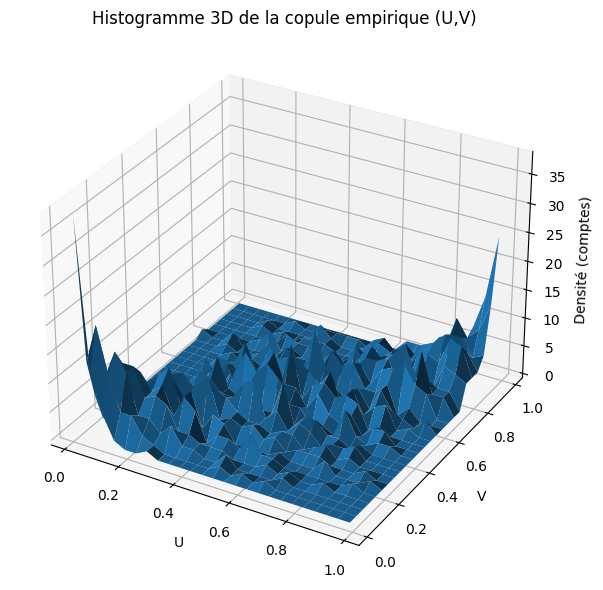

In [7]:
# ============================================================
# 3bis) "Copule empirique" : histogramme 3D 
# ============================================================
# On fait une grille 2D (bins x bins) sur (U,V) et on plot en 3D.
bins = 25
H, xedges, yedges = np.histogram2d(U, V, bins=bins, range=[[0,1],[0,1]])
H = H.T  # orientation

xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
Xg, Yg = np.meshgrid(xcenters, ycenters)

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Xg, Yg, H, linewidth=0)
ax.set_title("Histogramme 3D de la copule empirique (U,V)")
ax.set_xlabel("U")
ax.set_ylabel("V")
ax.set_zlabel("Densité (comptes)")
plt.tight_layout()
plt.show()

Estimation de la VaR par Monte Carlo + copule de Student :


========== VaR Monte Carlo - Copule t ==========
VaR 95% = 0.046002164122790214
VaR 99% = 0.08925210702026913


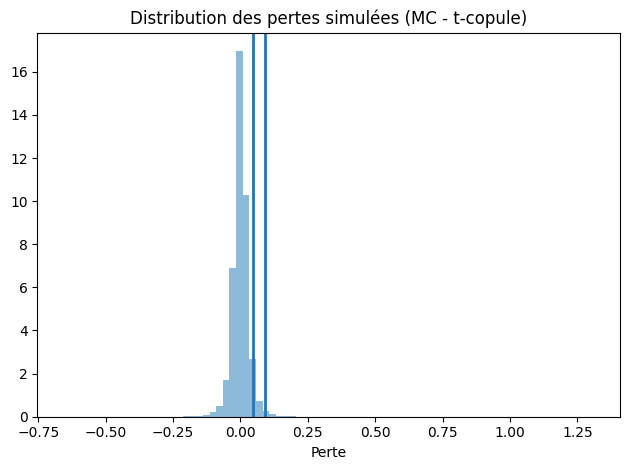

In [8]:
# ============================================================
# 17) SIMULATION MONTE CARLO VaR (t-copule + marges Student)
# ============================================================
# ============================================================
# Paramètres estimés de la copule t (utilisés pour la simulation)
# ============================================================
rho_est = float(fit_tcop["rho"])
df_est  = int(round(float(fit_tcop["df"])))


np.random.seed(123)

w_btc = 0.5
w_eth = 0.5

rho_hat = rho_est
df_cop = df_est

N = 100000

Z = np.random.multivariate_normal(mean=[0, 0], cov=[[1, rho_hat], [rho_hat, 1]], size=N)
W = np.random.chisquare(df_cop, size=N) / df_cop
Tsim = Z / np.sqrt(W)[:, None]

U_sim = safe_clip01(stats.t.cdf(Tsim[:, 0], df=df_cop))
V_sim = safe_clip01(stats.t.cdf(Tsim[:, 1], df=df_cop))

Rbtc_sim = qt_student(U_sim, df_X, mu_X, s_X)
Reth_sim = qt_student(V_sim, df_Y, mu_Y, s_Y)

Rport_sim = w_btc * Rbtc_sim + w_eth * Reth_sim
Loss_sim = -Rport_sim

VaR_95 = np.quantile(Loss_sim, 0.95)
VaR_99 = np.quantile(Loss_sim, 0.99)

print_header("VaR Monte Carlo - Copule t")
print("VaR 95% =", VaR_95)
print("VaR 99% =", VaR_99)

plt.figure()
plt.hist(Loss_sim, bins=80, density=True, alpha=0.5)
plt.axvline(VaR_95, linewidth=2)
plt.axvline(VaR_99, linewidth=2)
plt.title("Distribution des pertes simulées (MC - t-copule)")
plt.xlabel("Perte")
plt.tight_layout()
plt.show()

Estimation de la VaR historique :


========== VaR Historique BTC–ETH ==========
Poids BTC = 0.5 | Poids ETH = 0.5
VaR 95%  = 0.050294986681955506
VaR 99%  = 0.08668209246943827


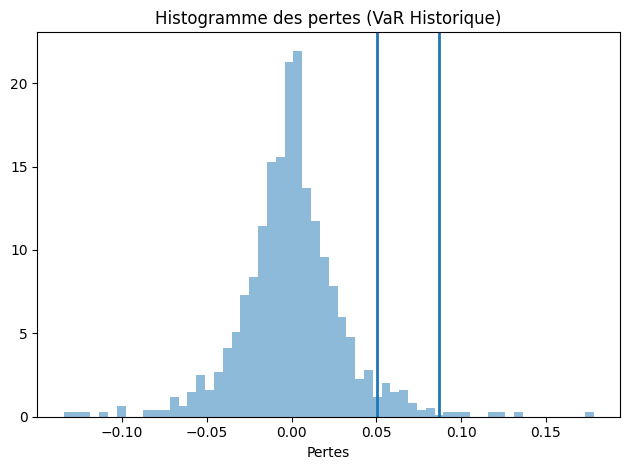

In [9]:
# ============================================================
# 18) VaR Historique
# ============================================================
R_port = w_btc * X + w_eth * Y
Loss_port = -R_port

VaR_hist_95 = np.quantile(Loss_port, 0.95)
VaR_hist_99 = np.quantile(Loss_port, 0.99)

print_header("VaR Historique BTC–ETH")
print("Poids BTC =", w_btc, "| Poids ETH =", w_eth)
print("VaR 95%  =", VaR_hist_95)
print("VaR 99%  =", VaR_hist_99)

plt.figure()
plt.hist(Loss_port, bins=60, density=True, alpha=0.5)
plt.axvline(VaR_hist_95, linewidth=2)
plt.axvline(VaR_hist_99, linewidth=2)
plt.title("Histogramme des pertes (VaR Historique)")
plt.xlabel("Pertes")
plt.tight_layout()
plt.show()

C:\Users\hbih\AppData\Local\Temp\ipykernel_30860\1452846727.py:37: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2022-01-01", progress=False)["Close"]



========== Taille échantillon ==========
n = 1444

========== Statistiques descriptives ==========
  Actif   Moyenne   Mediane  Ecart-type  Skewness  Kurtosis       Min  \
0   BTC  0.000416 -0.000240    0.027090 -0.152258  7.420924 -0.174053   
1   ETH -0.000158  0.000165    0.036675 -0.052696  7.034720 -0.191844   

        Max  
0  0.135764  
1  0.197200  

========== Copule t estimée ==========
rho = 0.84
df  = 5

========== VaR Monte Carlo (copule t) ==========
VaR 95% = 0.0459986036655655
VaR 99% = 0.08926300296749677

========== Kupiec backtesting ==========
Historique : (14, 0.009695290858725761, 0.013680904609264632, 0.9068874726700707)
Copule t   : (7, 0.004847645429362881, 4.781365945084302, 0.028769291730857405)


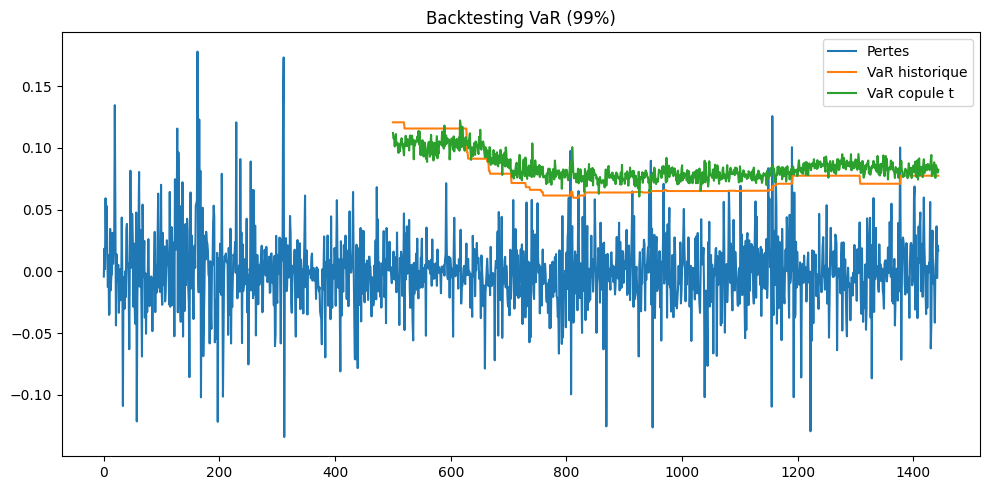

In [10]:
# ============================================================
# BTC / ETH – Copules – VaR – Backtesting 
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.special import gammaln
from scipy.stats import gaussian_kde
from statsmodels.stats.stattools import jarque_bera
import yfinance as yf

# ============================================================
# 0) Utils
# ============================================================
def print_header(title):
    print("\n" + "="*10 + f" {title} " + "="*10)

def safe_clip01(u, eps=1e-6):
    return np.clip(u, eps, 1-eps)

def pt_student(x, df, m, s):
    return stats.t.cdf((x-m)/s, df=df)

def qt_student(u, df, m, s):
    return m + s*stats.t.ppf(u, df=df)

def aic(loglik, k):
    return 2*k - 2*loglik

# ============================================================
# 1) Données et rendements
# ============================================================
tickers = ["BTC-USD", "ETH-USD"]
data = yf.download(tickers, start="2022-01-01", progress=False)["Close"]

rbtc = np.log(data["BTC-USD"]).diff().dropna()
reth = np.log(data["ETH-USD"]).diff().dropna()

df = pd.concat([rbtc, reth], axis=1).dropna()
df.columns = ["BTC", "ETH"]

X = df["BTC"].values
Y = df["ETH"].values
n = len(X)

print_header("Taille échantillon")
print("n =", n)

# ============================================================
# 2) Statistiques descriptives
# ============================================================
print_header("Statistiques descriptives")
stats_df = pd.DataFrame({
    "Actif": ["BTC","ETH"],
    "Moyenne": [X.mean(), Y.mean()],
    "Mediane": [np.median(X), np.median(Y)],
    "Ecart-type": [X.std(ddof=1), Y.std(ddof=1)],
    "Skewness": [stats.skew(X), stats.skew(Y)],
    "Kurtosis": [stats.kurtosis(X,fisher=False), stats.kurtosis(Y,fisher=False)],
    "Min": [X.min(), Y.min()],
    "Max": [X.max(), Y.max()]
})
print(stats_df)

# ============================================================
# 3) Marges Student-t (MLE)
# ============================================================
df_X, mu_X, s_X = stats.t.fit(X)
df_Y, mu_Y, s_Y = stats.t.fit(Y)

# ============================================================
# 4) PIT (marges Student)
# ============================================================
U = safe_clip01(pt_student(X, df_X, mu_X, s_X))
V = safe_clip01(pt_student(Y, df_Y, mu_Y, s_Y))

# ============================================================
# 5) Copule t – log densité
# ============================================================
def copula_t_logpdf(u, v, rho, df):
    x = stats.t.ppf(u, df)
    y = stats.t.ppf(v, df)
    det = 1-rho**2
    Q = (x**2 - 2*rho*x*y + y**2)/det
    c = gammaln((df+2)/2) - gammaln(df/2) - np.log(df*np.pi)
    log_f2 = c - 0.5*np.log(det) - (df+2)/2*np.log1p(Q/df)
    log_f1 = stats.t.logpdf(x,df) + stats.t.logpdf(y,df)
    return log_f2 - log_f1

# ============================================================
# 6) Estimation copule t (UNE SEULE FOIS)
# ============================================================
best_ll = -np.inf
for rho in np.linspace(-0.9,0.9,181):
    for dfc in [3,4,5,6,8,10,15,20]:
        ll = np.sum(copula_t_logpdf(U,V,rho,dfc))
        if np.isfinite(ll) and ll > best_ll:
            best_ll = ll
            rho_hat, df_cop = rho, dfc

print_header("Copule t estimée")
print("rho =", rho_hat)
print("df  =", df_cop)

# ============================================================
# 7) VaR Monte Carlo (copule t)
# ============================================================
np.random.seed(123)
N = 100000
Z = np.random.multivariate_normal([0,0], [[1,rho_hat],[rho_hat,1]], N)
W = np.random.chisquare(df_cop,N)/df_cop
T = Z/np.sqrt(W)[:,None]

U_sim = safe_clip01(stats.t.cdf(T[:,0],df_cop))
V_sim = safe_clip01(stats.t.cdf(T[:,1],df_cop))

Rbtc = qt_student(U_sim, df_X, mu_X, s_X)
Reth = qt_student(V_sim, df_Y, mu_Y, s_Y)

R_port = 0.5*Rbtc + 0.5*Reth
Loss_mc = -R_port

VaR95_mc = np.quantile(Loss_mc,0.95)
VaR99_mc = np.quantile(Loss_mc,0.99)

print_header("VaR Monte Carlo (copule t)")
print("VaR 95% =", VaR95_mc)
print("VaR 99% =", VaR99_mc)

# ============================================================
# 8) VaR Historique
# ============================================================
Loss_hist = -(0.5*X + 0.5*Y)
VaR95_h = np.quantile(Loss_hist,0.95)
VaR99_h = np.quantile(Loss_hist,0.99)

# ============================================================
# 9) BACKTESTING (version corrigée)
# ============================================================
alpha = 0.99
window = 500
T = len(Loss_hist)

VaR_hist_roll = np.full(T,np.nan)
VaR_mc_roll   = np.full(T,np.nan)

for t in range(window,T):
    Lw = Loss_hist[t-window:t]
    VaR_hist_roll[t] = np.quantile(Lw,alpha)

    # Refit marges uniquement
    Xw, Yw = X[t-window:t], Y[t-window:t]
    dfX, mX, sX = stats.t.fit(Xw)
    dfY, mY, sY = stats.t.fit(Yw)

    Z = np.random.multivariate_normal([0,0], [[1,rho_hat],[rho_hat,1]], 5000)
    W = np.random.chisquare(df_cop,5000)/df_cop
    Tsim = Z/np.sqrt(W)[:,None]

    Rb = qt_student(stats.t.cdf(Tsim[:,0],df_cop), dfX, mX, sX)
    Re = qt_student(stats.t.cdf(Tsim[:,1],df_cop), dfY, mY, sY)

    VaR_mc_roll[t] = np.quantile(-(0.5*Rb+0.5*Re), alpha)

# ============================================================
# 10) Kupiec test
# ============================================================
def kupiec(viol,alpha):
    viol = viol[~np.isnan(viol)]
    x = viol.sum()
    Tn = len(viol)
    p0 = 1-alpha
    phat = x/Tn
    LR = -2*((Tn-x)*np.log((1-p0)/(1-phat)) + x*np.log(p0/phat))
    pval = 1-stats.chi2.cdf(LR,1)
    return x,phat,LR,pval

viol_h = Loss_hist > VaR_hist_roll
viol_mc = Loss_hist > VaR_mc_roll

print_header("Kupiec backtesting")
print("Historique :", kupiec(viol_h,alpha))
print("Copule t   :", kupiec(viol_mc,alpha))

# ============================================================
# 11) Graphique final
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(Loss_hist,label="Pertes")
plt.plot(VaR_hist_roll,label="VaR historique")
plt.plot(VaR_mc_roll,label="VaR copule t")
plt.legend()
plt.title("Backtesting VaR (99%)")
plt.tight_layout()
plt.show()